In [1]:
!pip install -q transformers datasets accelerate sentencepiece
!pip install -q scikit-learn pandas numpy matplotlib seaborn


In [2]:
# =============================================================================
# CELDA 0: MONTAR GOOGLE DRIVE (ejecutar primero)
# =============================================================================
"""
🔌 MONTAR GOOGLE DRIVE

Ejecuta esta celda para montar tu Google Drive y acceder a los archivos.
Después de ejecutar, tus archivos estarán en /content/drive/MyDrive/
"""

from google.colab import drive
drive.mount('/content/drive')

# Verificar que se montó correctamente
import os
print("✅ Google Drive montado")
print("\n📁 Contenido de MyDrive (primeros 10):")
for f in os.listdir('/content/drive/MyDrive')[:10]:
    print(f"   {f}")

Mounted at /content/drive
✅ Google Drive montado

📁 Contenido de MyDrive (primeros 10):
   Colab Notebooks
   .ipynb_checkpoints
   severstal
   unet_dataset
   NEU_Defect_Project
   diffusers
   ML-and-DL-final-project
   Metal-Surface-Defect-Detection
   dataset
   runs


In [5]:
# =============================================================================
# CELDA 1: INSTALACIÓN DE DEPENDENCIAS
# =============================================================================
"""
# 🔬 Detección de Toxicidad en Español - V2 MEJORADA
## Competición DETOXIS

### Mejoras en esta versión:
- Oversampling de clases minoritarias
- Pseudo-labeling
- Optimización de umbrales por clase
- MAX_LENGTH aumentado a 384
- Mejor manejo del desbalance extremo (33.6x)

### ⚠️ COLUMNAS:
- Train: 'text'
- Test: 'comment'
"""

!pip install -q transformers datasets accelerate sentencepiece
!pip install -q scikit-learn pandas numpy matplotlib seaborn
!pip install -q imbalanced-learn  # Para oversampling

print("✅ Dependencias instaladas")

✅ Dependencias instaladas


In [6]:
# =============================================================================
# CELDA 2: IMPORTS
# =============================================================================

import os
import gc
import json
import warnings
import random
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix,
    precision_recall_fscore_support
)
from sklearn.utils.class_weight import compute_class_weight

# Imbalanced-learn para oversampling
from imblearn.over_sampling import RandomOverSampler

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler

# Transformers
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    AutoModelForMaskedLM, AutoConfig,
    DataCollatorForLanguageModeling,
    get_linear_schedule_with_warmup,
    logging as transformers_logging
)

warnings.filterwarnings('ignore')
transformers_logging.set_verbosity_error()

print(f"PyTorch: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch: 2.9.0+cu126
CUDA disponible: True
GPU: NVIDIA L4


In [ ]:
%ls


drive/  sample_data/


In [ ]:
%cd drive

/content/drive


In [18]:
# =============================================================================
# CELDA 3: CONFIGURACIÓN GLOBAL
# =============================================================================
"""
⚙️ CONFIGURACIÓN PRINCIPAL

Modifica aquí:
- Rutas de archivos (ajusta según donde subiste los CSV)
- Hiperparámetros
- Opciones de entrenamiento
"""

@dataclass
class Config:
    """Configuración centralizada"""

    # === RUTAS ===
    # Opción 1: Si subiste los CSV directamente a Colab
    #TRAIN_PATH: str = "Detoxis_train_kaggle.csv"
    #TEST_PATH: str = "Detoxis_test_kaggle.csv"

    # Opción 2: Si los tienes en Google Drive, descomenta y ajusta:
    TRAIN_PATH: str = "/content/drive/MyDrive/NLP/Detoxis_train_kaggle.csv"
    TEST_PATH: str = "/content/drive/MyDrive/NLP/Detoxis_test_kaggle.csv"

    OUTPUT_DIR: str = "/outputs"

    # === COLUMNAS - ¡¡NO CAMBIAR!! ===
    TRAIN_TEXT_COL: str = "text"      # Train usa 'text'
    TEST_TEXT_COL: str = "comment"    # Test usa 'comment'
    LABEL_COL: str = "label"
    ID_COL: str = "id"

    # === Reproducibilidad ===
    SEED: int = 42
    N_FOLDS: int = 5

    # === Modelos (salta automáticamente los gated) ===
    MODEL_CANDIDATES: Tuple[str, ...] = (
        "dccuchile/bert-base-spanish-wwm-cased",  # BETO - mejor para español
        "xlm-roberta-base",
        "bert-base-multilingual-cased",
    )

    # === Transformer (AJUSTADO para dataset real) ===
    MAX_LENGTH: int = 384        # Aumentado (P95 ~640 chars)
    BATCH_SIZE: int = 16
    LEARNING_RATE: float = 2e-5
    WEIGHT_DECAY: float = 0.01
    EPOCHS: int = 6              # Más epochs para clases raras
    WARMUP_RATIO: float = 0.1
    GRADIENT_CLIP: float = 1.0
    EARLY_STOPPING_PATIENCE: int = 2

    # === TF-IDF ===
    TFIDF_MAX_FEATURES: int = 50000
    TFIDF_NGRAM_RANGE: Tuple[int, int] = (2, 6)  # Char n-grams más largos

    # === TAPT ===
    ENABLE_TAPT: bool = True
    TAPT_EPOCHS: int = 2
    TAPT_LR: float = 5e-5

    # === NUEVAS OPCIONES ===
    ENABLE_OVERSAMPLING: bool = True      # Oversampling de clases minoritarias
    ENABLE_PSEUDO_LABELING: bool = True   # Pseudo-labeling con test
    PSEUDO_THRESHOLD: float = 0.90        # Umbral de confianza
    ENABLE_THRESHOLD_OPT: bool = True     # Optimizar umbrales por clase

    # === Ensemble ===
    BASELINE_WEIGHT: float = 0.25
    TRANSFORMER_WEIGHT: float = 0.75

    # === Clases ===
    NUM_CLASSES: int = 4
    CLASS_NAMES: Tuple[str, ...] = ("No tóxico", "Leve", "Tóxico", "Muy tóxico")

CONFIG = Config()
os.makedirs(CONFIG.OUTPUT_DIR, exist_ok=True)

print("📋 Configuración cargada:")
print(f"   Train: {CONFIG.TRAIN_PATH} (col: '{CONFIG.TRAIN_TEXT_COL}')")
print(f"   Test: {CONFIG.TEST_PATH} (col: '{CONFIG.TEST_TEXT_COL}')")
print(f"   Oversampling: {CONFIG.ENABLE_OVERSAMPLING}")
print(f"   Pseudo-labeling: {CONFIG.ENABLE_PSEUDO_LABELING}")
print(f"   Threshold optimization: {CONFIG.ENABLE_THRESHOLD_OPT}")


📋 Configuración cargada:
   Train: /content/drive/MyDrive/NLP/Detoxis_train_kaggle.csv (col: 'text')
   Test: /content/drive/MyDrive/NLP/Detoxis_test_kaggle.csv (col: 'comment')
   Oversampling: True
   Pseudo-labeling: True
   Threshold optimization: True


In [17]:
%ls


drive/  sample_data/


In [15]:
# =============================================================================
# CELDA 4: FUNCIONES DE UTILIDAD
# =============================================================================

def set_seed(seed: int = 42):
    """Fija semillas"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED'] = str(seed)

def get_device():
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def clear_gpu_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def compute_metrics(y_true, y_pred, class_names=None):
    """Calcula macro-F1 y F1 por clase"""
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    precision, recall, f1_per_class, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )
    if class_names is None:
        class_names = [f"Clase {i}" for i in range(len(f1_per_class))]
    report = classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0)
    return {
        'macro_f1': macro_f1,
        'f1_per_class': f1_per_class,
        'precision_per_class': precision,
        'recall_per_class': recall,
        'support_per_class': support,
        'report': report
    }

def plot_confusion_matrix(y_true, y_pred, class_names, title="Matriz de Confusión"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.tight_layout()
    plt.show()

def optimize_thresholds(proba: np.ndarray, y_true: np.ndarray, num_classes: int) -> np.ndarray:
    """
    Optimiza umbrales/bias por clase para maximizar macro-F1.
    Añade un bias a los logits de cada clase.
    """
    print("🔧 Optimizando umbrales por clase...")

    best_f1 = 0
    best_bias = np.zeros(num_classes)

    # Grid search sobre bias
    for c in range(num_classes):
        for bias in np.arange(-0.5, 0.51, 0.05):
            test_bias = best_bias.copy()
            test_bias[c] = bias

            adjusted_proba = proba + test_bias
            preds = adjusted_proba.argmax(axis=1)
            f1 = f1_score(y_true, preds, average='macro')

            if f1 > best_f1:
                best_f1 = f1
                best_bias = test_bias.copy()

    print(f"   Bias óptimos: {[f'{b:.2f}' for b in best_bias]}")
    print(f"   Macro-F1 mejorado: {best_f1:.4f}")

    return best_bias

set_seed(CONFIG.SEED)
DEVICE = get_device()
print(f"🖥️ Dispositivo: {DEVICE}")

🖥️ Dispositivo: cuda


In [19]:
# =============================================================================
# CELDA 5: CARGA DE DATOS
# =============================================================================

def load_data(config):
    """Carga y valida los datos"""
    print("📂 Cargando datos...")

    train_df = pd.read_csv(config.TRAIN_PATH)
    test_df = pd.read_csv(config.TEST_PATH)

    print(f"   Train: {len(train_df)} filas, columnas: {list(train_df.columns)}")
    print(f"   Test: {len(test_df)} filas, columnas: {list(test_df.columns)}")

    # Validar columnas
    assert config.TRAIN_TEXT_COL in train_df.columns, \
        f"❌ No existe '{config.TRAIN_TEXT_COL}' en train. Columnas: {list(train_df.columns)}"
    assert config.TEST_TEXT_COL in test_df.columns, \
        f"❌ No existe '{config.TEST_TEXT_COL}' en test. Columnas: {list(test_df.columns)}"

    # Limpiar
    train_df[config.TRAIN_TEXT_COL] = train_df[config.TRAIN_TEXT_COL].fillna("").astype(str)
    test_df[config.TEST_TEXT_COL] = test_df[config.TEST_TEXT_COL].fillna("").astype(str)
    train_df[config.LABEL_COL] = train_df[config.LABEL_COL].astype(int)

    print("✅ Datos cargados")
    return train_df, test_df

train_df, test_df = load_data(CONFIG)

📂 Cargando datos...
   Train: 3463 filas, columnas: ['id', 'text', 'label']
   Test: 891 filas, columnas: ['id', 'comment']
✅ Datos cargados


📊 DISTRIBUCIÓN DE CLASES


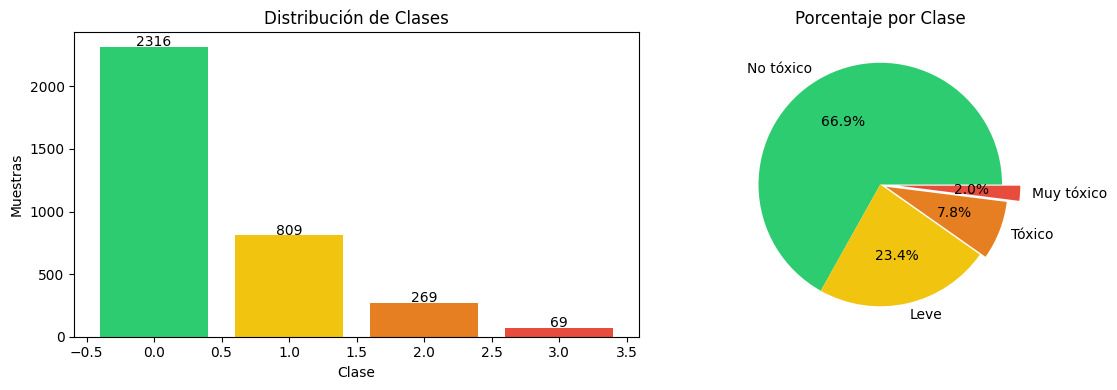


📊 Estadísticas de desbalance:
   Clase 0 (No tóxico): 2316 (66.9%)
   Clase 1 (Leve): 809 (23.4%)
   Clase 2 (Tóxico): 269 (7.8%)
   Clase 3 (Muy tóxico): 69 (2.0%)

⚠️ Ratio desbalance: 33.6x
⚠️ Clase 3 ('Muy tóxico') tiene solo 69 muestras!


In [20]:
# =============================================================================
# CELDA 6: EDA - DISTRIBUCIÓN DE CLASES
# =============================================================================

print("=" * 60)
print("📊 DISTRIBUCIÓN DE CLASES")
print("=" * 60)

class_counts = train_df[CONFIG.LABEL_COL].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']
bars = axes[0].bar(class_counts.index, class_counts.values, color=colors)
axes[0].set_xlabel('Clase')
axes[0].set_ylabel('Muestras')
axes[0].set_title('Distribución de Clases')
for bar, count in zip(bars, class_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f'{count}', ha='center', fontsize=10)

axes[1].pie(class_counts.values, labels=CONFIG.CLASS_NAMES, autopct='%1.1f%%',
           colors=colors, explode=[0, 0, 0.05, 0.15])
axes[1].set_title('Porcentaje por Clase')
plt.tight_layout()
plt.show()

print("\n📊 Estadísticas de desbalance:")
for i, name in enumerate(CONFIG.CLASS_NAMES):
    count = class_counts.get(i, 0)
    pct = 100 * count / len(train_df)
    print(f"   Clase {i} ({name}): {count} ({pct:.1f}%)")

ratio = class_counts.max() / class_counts.min()
print(f"\n⚠️ Ratio desbalance: {ratio:.1f}x")
print(f"⚠️ Clase 3 ('Muy tóxico') tiene solo {class_counts.get(3, 0)} muestras!")


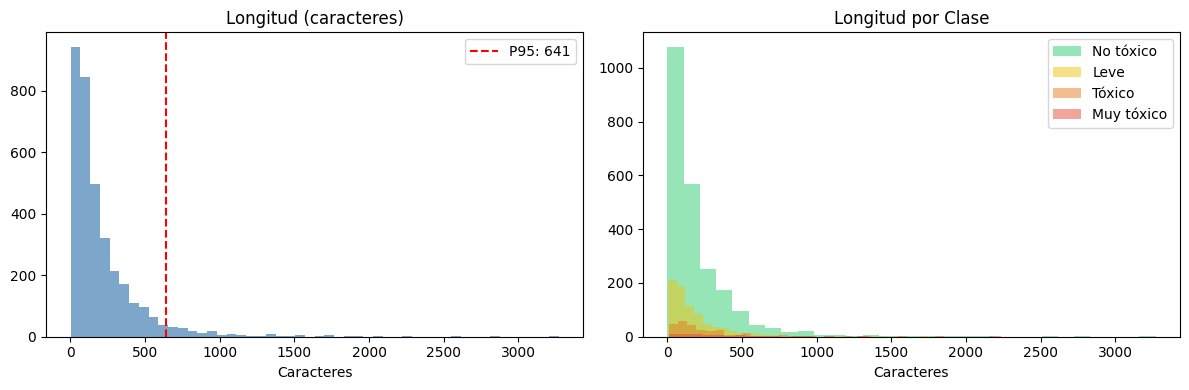


📏 Estadísticas de longitud por clase:
   Clase 0: media=199, mediana=120, max=3270
   Clase 1: media=198, mediana=123, max=1747
   Clase 2: media=258, mediana=177, max=1852
   Clase 3: media=349, mediana=257, max=2234


In [21]:
# =============================================================================
# CELDA 7: EDA - LONGITUD Y CARACTERÍSTICAS
# =============================================================================

train_df['char_len'] = train_df[CONFIG.TRAIN_TEXT_COL].str.len()
train_df['word_count'] = train_df[CONFIG.TRAIN_TEXT_COL].str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(train_df['char_len'], bins=50, color='steelblue', alpha=0.7)
axes[0].axvline(train_df['char_len'].quantile(0.95), color='red', linestyle='--',
               label=f"P95: {train_df['char_len'].quantile(0.95):.0f}")
axes[0].set_xlabel('Caracteres')
axes[0].set_title('Longitud (caracteres)')
axes[0].legend()

# Longitud por clase
for i, color in enumerate(colors):
    subset = train_df[train_df[CONFIG.LABEL_COL] == i]['char_len']
    axes[1].hist(subset, bins=30, alpha=0.5, label=CONFIG.CLASS_NAMES[i], color=color)
axes[1].set_xlabel('Caracteres')
axes[1].set_title('Longitud por Clase')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\n📏 Estadísticas de longitud por clase:")
for i, name in enumerate(CONFIG.CLASS_NAMES):
    subset = train_df[train_df[CONFIG.LABEL_COL] == i]
    print(f"   Clase {i}: media={subset['char_len'].mean():.0f}, "
          f"mediana={subset['char_len'].median():.0f}, max={subset['char_len'].max()}")


In [22]:
# =============================================================================
# CELDA 8: EDA - EJEMPLOS POR CLASE
# =============================================================================

print("=" * 60)
print("📝 EJEMPLOS POR CLASE")
print("=" * 60)

for class_id, class_name in enumerate(CONFIG.CLASS_NAMES):
    class_df = train_df[train_df[CONFIG.LABEL_COL] == class_id]
    print(f"\n🏷️ CLASE {class_id}: {class_name} ({len(class_df)} muestras)")
    print("-" * 50)

    samples = class_df.sample(min(2, len(class_df)), random_state=CONFIG.SEED)
    for idx, (_, row) in enumerate(samples.iterrows(), 1):
        text = row[CONFIG.TRAIN_TEXT_COL][:250] + "..." if len(row[CONFIG.TRAIN_TEXT_COL]) > 250 else row[CONFIG.TRAIN_TEXT_COL]
        print(f"   {idx}. \"{text}\"")


📝 EJEMPLOS POR CLASE

🏷️ CLASE 0: No tóxico (2316 muestras)
--------------------------------------------------
   1. "¿Por que? Parece una gestión de la cosa pública un poco deficiente, ¿no?"
   2. "Son marroquíes. Menores. No se adaptan aquí. Han delinquido. No es racismo. Es sentido comun. Vuelven a su país, a su cultura, su entorno, sus costumbres. Allí seguro sabrán tratarlos mejor que nosotros. No hay más. "

🏷️ CLASE 1: Leve (809 muestras)
--------------------------------------------------
   1. "A estos imanes radicales, avión y deportados al Sahara o a Vladivostok, pero ya. No queremos esa gente aquí."
   2. "Me gustan los hombres viriles, no soporto a los hombres femininos. Hay muchos en Europa. Esto no quiere decir que me gusten las personas violentas. Los violentos deben ser esterilizados."

🏷️ CLASE 2: Tóxico (269 muestras)
--------------------------------------------------
   1. "ojalá más como él puedan llegar a España, nos pagarán las pensiones y violarán a nuestras hija


🔧 BASELINE: TF-IDF + LOGISTIC REGRESSION

📁 Fold 1/5
   Oversampling: 7412 muestras
   Macro-F1: 0.3276
   F1 por clase: ['0.8024', '0.3451', '0.1628', '0.0000']

📁 Fold 2/5
   Oversampling: 7412 muestras
   Macro-F1: 0.4066
   F1 por clase: ['0.7959', '0.3605', '0.2198', '0.2500']

📁 Fold 3/5
   Oversampling: 7412 muestras
   Macro-F1: 0.3758
   F1 por clase: ['0.8041', '0.3624', '0.2366', '0.1000']

📁 Fold 4/5
   Oversampling: 7408 muestras
   Macro-F1: 0.3196
   F1 por clase: ['0.8032', '0.3162', '0.1591', '0.0000']

📁 Fold 5/5
   Oversampling: 7412 muestras
   Macro-F1: 0.4263
   F1 por clase: ['0.7992', '0.3217', '0.2316', '0.3529']

📊 BASELINE - RESULTADOS OOF
              precision    recall  f1-score   support

   No tóxico     0.7548    0.8532    0.8010      2316
        Leve     0.3851    0.3066    0.3414       809
      Tóxico     0.2500    0.1710    0.2031       269
  Muy tóxico     0.3529    0.0870    0.1395        69

    accuracy                         0.6572      346

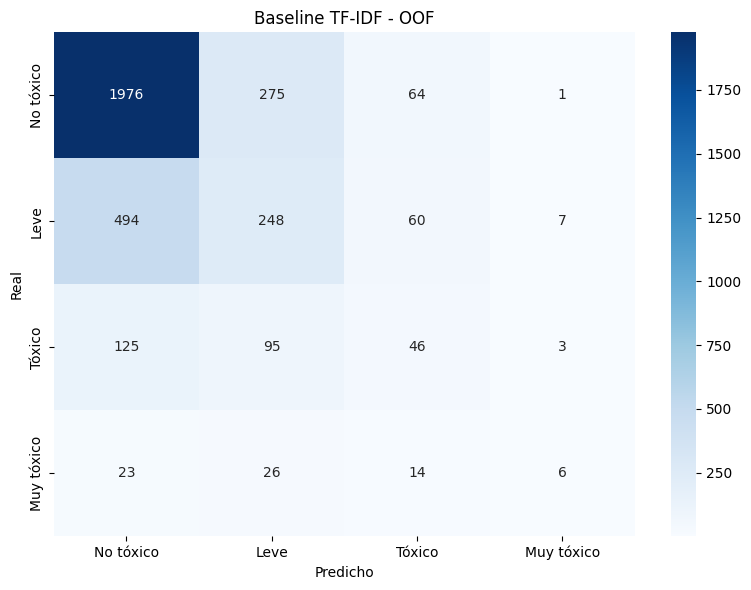


✅ Baseline Macro-F1 (OOF): 0.3712


In [23]:
# =============================================================================
# CELDA 9: BASELINE TF-IDF CON OVERSAMPLING
# =============================================================================

print("\n" + "=" * 60)
print("🔧 BASELINE: TF-IDF + LOGISTIC REGRESSION")
print("=" * 60)

class TFIDFBaseline:
    """Baseline con TF-IDF y oversampling opcional"""

    def __init__(self, config, use_oversampling=True):
        self.config = config
        self.use_oversampling = use_oversampling
        self.vectorizer = TfidfVectorizer(
            analyzer='char_wb',  # char con word boundaries
            ngram_range=config.TFIDF_NGRAM_RANGE,
            max_features=config.TFIDF_MAX_FEATURES,
            sublinear_tf=True,
            min_df=2,
            max_df=0.95
        )
        self.classifier = None

    def fit(self, X_train, y_train):
        X_tfidf = self.vectorizer.fit_transform(X_train)

        # Oversampling
        if self.use_oversampling:
            ros = RandomOverSampler(random_state=self.config.SEED)
            X_tfidf, y_train = ros.fit_resample(X_tfidf, y_train)
            print(f"   Oversampling: {len(y_train)} muestras")

        base_clf = LogisticRegression(
            class_weight='balanced',
            max_iter=1000,
            solver='lbfgs',
            multi_class='multinomial',
            random_state=self.config.SEED,
            C=1.0,
            n_jobs=-1
        )
        self.classifier = CalibratedClassifierCV(base_clf, cv=3, method='sigmoid')
        self.classifier.fit(X_tfidf, y_train)
        return self

    def predict(self, X):
        X_tfidf = self.vectorizer.transform(X)
        return self.classifier.predict(X_tfidf)

    def predict_proba(self, X):
        X_tfidf = self.vectorizer.transform(X)
        return self.classifier.predict_proba(X_tfidf)

# Entrenar con CV
X = train_df[CONFIG.TRAIN_TEXT_COL].values
y = train_df[CONFIG.LABEL_COL].values

baseline_oof_proba = np.zeros((len(X), CONFIG.NUM_CLASSES))
skf = StratifiedKFold(n_splits=CONFIG.N_FOLDS, shuffle=True, random_state=CONFIG.SEED)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n📁 Fold {fold}/{CONFIG.N_FOLDS}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = TFIDFBaseline(CONFIG, use_oversampling=CONFIG.ENABLE_OVERSAMPLING)
    model.fit(X_train, y_train)

    val_proba = model.predict_proba(X_val)
    baseline_oof_proba[val_idx] = val_proba

    val_preds = val_proba.argmax(axis=1)
    metrics = compute_metrics(y_val, val_preds, list(CONFIG.CLASS_NAMES))
    print(f"   Macro-F1: {metrics['macro_f1']:.4f}")
    print(f"   F1 por clase: {[f'{f:.4f}' for f in metrics['f1_per_class']]}")

# Resultados
baseline_oof_preds = baseline_oof_proba.argmax(axis=1)
baseline_metrics = compute_metrics(y, baseline_oof_preds, list(CONFIG.CLASS_NAMES))

print("\n" + "=" * 60)
print("📊 BASELINE - RESULTADOS OOF")
print("=" * 60)
print(baseline_metrics['report'])
plot_confusion_matrix(y, baseline_oof_preds, list(CONFIG.CLASS_NAMES), "Baseline TF-IDF - OOF")

print(f"\n✅ Baseline Macro-F1 (OOF): {baseline_metrics['macro_f1']:.4f}")


In [24]:
# =============================================================================
# CELDA 10: DATASET Y CLASES PARA TRANSFORMER
# =============================================================================

class ToxicityDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts[idx]),
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        item = {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0)
        }
        if self.labels is not None:
            item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

class FocalLoss(nn.Module):
    """Focal Loss para desbalance extremo"""
    def __init__(self, alpha=None, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss
        if self.alpha is not None:
            alpha_t = self.alpha.to(inputs.device)[targets]
            focal_loss = alpha_t * focal_loss
        return focal_loss.mean()

def get_weighted_sampler(labels: np.ndarray) -> WeightedRandomSampler:
    """Crea un sampler ponderado para oversampling durante entrenamiento"""
    class_counts = np.bincount(labels)
    weights = 1.0 / class_counts
    sample_weights = weights[labels]
    return WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

print("✅ Clases definidas")


✅ Clases definidas


In [25]:
# =============================================================================
# CELDA 11: SELECCIÓN DE MODELO
# =============================================================================

def select_model(candidates):
    """Selecciona el primer modelo disponible"""
    print("\n🔍 Buscando modelo...")

    for name in candidates:
        try:
            print(f"   Probando {name}...", end=" ")
            tokenizer = AutoTokenizer.from_pretrained(name)
            _ = AutoConfig.from_pretrained(name)
            print("✅")
            return name, tokenizer
        except Exception as e:
            err = str(e).lower()
            if 'token' in err or 'gated' in err or 'auth' in err:
                print("❌ Requiere token")
            else:
                print(f"❌ {str(e)[:40]}")

    raise RuntimeError("No se pudo cargar ningún modelo")

MODEL_NAME, tokenizer = select_model(CONFIG.MODEL_CANDIDATES)
print(f"\n🎯 Modelo: {MODEL_NAME}")

# Pesos de clase (aumentados para clase 3)
class_weights = torch.tensor(
    compute_class_weight('balanced', classes=np.arange(CONFIG.NUM_CLASSES), y=y),
    dtype=torch.float32
)
# Aumentar peso de clase 3 aún más
class_weights[3] *= 1.5
print(f"\n⚖️ Pesos de clase (ajustados): {[f'{w:.2f}' for w in class_weights]}")



🔍 Buscando modelo...
   Probando dccuchile/bert-base-spanish-wwm-cased... 

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

✅

🎯 Modelo: dccuchile/bert-base-spanish-wwm-cased

⚖️ Pesos de clase (ajustados): ['0.37', '1.07', '3.22', '18.82']


In [26]:
# =============================================================================
# CELDA 12: TAPT (OPCIONAL)
# =============================================================================

ADAPTED_MODEL_PATH = MODEL_NAME

if CONFIG.ENABLE_TAPT:
    print("\n" + "=" * 60)
    print("🔄 TAPT: Task-Adaptive Pre-Training")
    print("=" * 60)

    all_texts = list(train_df[CONFIG.TRAIN_TEXT_COL].values) + list(test_df[CONFIG.TEST_TEXT_COL].values)
    print(f"   Textos para MLM: {len(all_texts)}")

    class MLMDataset(Dataset):
        def __init__(self, texts, tokenizer, max_length):
            self.texts = texts
            self.tokenizer = tokenizer
            self.max_length = max_length
        def __len__(self):
            return len(self.texts)
        def __getitem__(self, idx):
            enc = self.tokenizer(str(self.texts[idx]), max_length=self.max_length,
                                padding='max_length', truncation=True, return_tensors='pt')
            return {'input_ids': enc['input_ids'].squeeze(), 'attention_mask': enc['attention_mask'].squeeze()}

    mlm_model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME).to(DEVICE)
    mlm_dataset = MLMDataset(all_texts, tokenizer, CONFIG.MAX_LENGTH)
    collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)
    mlm_loader = DataLoader(mlm_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True, collate_fn=collator)

    optimizer = torch.optim.AdamW(mlm_model.parameters(), lr=CONFIG.TAPT_LR)
    scaler = GradScaler()

    mlm_model.train()
    for epoch in range(CONFIG.TAPT_EPOCHS):
        total_loss = 0
        for batch in mlm_loader:
            batch = {k: v.to(DEVICE) for k, v in batch.items()}
            optimizer.zero_grad()
            with autocast():
                loss = mlm_model(**batch).loss
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item()
        print(f"   Epoch {epoch+1}/{CONFIG.TAPT_EPOCHS} - MLM Loss: {total_loss/len(mlm_loader):.4f}")

    ADAPTED_MODEL_PATH = os.path.join(CONFIG.OUTPUT_DIR, "tapt_model")
    mlm_model.save_pretrained(ADAPTED_MODEL_PATH)
    tokenizer.save_pretrained(ADAPTED_MODEL_PATH)
    del mlm_model
    clear_gpu_memory()
    print(f"✅ TAPT: {ADAPTED_MODEL_PATH}")
else:
    print("\n⏭️ TAPT desactivado")



🔄 TAPT: Task-Adaptive Pre-Training
   Textos para MLM: 4354


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/204 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

   Epoch 1/2 - MLM Loss: 2.5953
   Epoch 2/2 - MLM Loss: 2.3722


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

✅ TAPT: /outputs/tapt_model



🤖 TRANSFORMER CON K-FOLD

──────────────────────────────────────────────────
📁 Fold 1/5
──────────────────────────────────────────────────


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

   Epoch 1/6 | Loss: 1.0960 | Macro-F1: 0.0940 | F1/clase: ['0.026', '0.172', '0.179', '0.000']
   Epoch 2/6 | Loss: 0.1870 | Macro-F1: 0.4053 | F1/clase: ['0.729', '0.340', '0.204', '0.348']
   Epoch 3/6 | Loss: 0.0742 | Macro-F1: 0.3517 | F1/clase: ['0.518', '0.383', '0.271', '0.235']
   Epoch 4/6 | Loss: 0.0430 | Macro-F1: 0.4253 | F1/clase: ['0.699', '0.410', '0.259', '0.333']
   Epoch 5/6 | Loss: 0.0194 | Macro-F1: 0.3797 | F1/clase: ['0.774', '0.421', '0.113', '0.211']
   Epoch 6/6 | Loss: 0.0156 | Macro-F1: 0.4032 | F1/clase: ['0.766', '0.407', '0.154', '0.286']
   ⏹️ Early stopping

──────────────────────────────────────────────────
📁 Fold 2/5
──────────────────────────────────────────────────


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

   Epoch 1/6 | Loss: 1.4967 | Macro-F1: 0.1727 | F1/clase: ['0.013', '0.268', '0.220', '0.190']
   Epoch 2/6 | Loss: 0.2002 | Macro-F1: 0.4030 | F1/clase: ['0.688', '0.409', '0.314', '0.200']
   Epoch 3/6 | Loss: 0.0706 | Macro-F1: 0.4006 | F1/clase: ['0.646', '0.456', '0.215', '0.286']
   Epoch 4/6 | Loss: 0.0363 | Macro-F1: 0.4688 | F1/clase: ['0.773', '0.497', '0.242', '0.364']
   Epoch 5/6 | Loss: 0.0206 | Macro-F1: 0.4489 | F1/clase: ['0.771', '0.492', '0.247', '0.286']
   Epoch 6/6 | Loss: 0.0151 | Macro-F1: 0.4486 | F1/clase: ['0.778', '0.492', '0.225', '0.300']
   ⏹️ Early stopping

──────────────────────────────────────────────────
📁 Fold 3/5
──────────────────────────────────────────────────


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

   Epoch 1/6 | Loss: 1.3505 | Macro-F1: 0.1900 | F1/clase: ['0.030', '0.321', '0.209', '0.200']
   Epoch 2/6 | Loss: 0.1748 | Macro-F1: 0.2403 | F1/clase: ['0.129', '0.350', '0.260', '0.222']
   Epoch 3/6 | Loss: 0.0677 | Macro-F1: 0.4032 | F1/clase: ['0.713', '0.413', '0.276', '0.211']
   Epoch 4/6 | Loss: 0.0356 | Macro-F1: 0.4098 | F1/clase: ['0.803', '0.455', '0.182', '0.200']
   Epoch 5/6 | Loss: 0.0194 | Macro-F1: 0.4220 | F1/clase: ['0.782', '0.471', '0.235', '0.200']
   Epoch 6/6 | Loss: 0.0171 | Macro-F1: 0.4224 | F1/clase: ['0.777', '0.480', '0.222', '0.211']

──────────────────────────────────────────────────
📁 Fold 4/5
──────────────────────────────────────────────────


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

   Epoch 1/6 | Loss: 1.2344 | Macro-F1: 0.2155 | F1/clase: ['0.251', '0.220', '0.190', '0.200']
   Epoch 2/6 | Loss: 0.1829 | Macro-F1: 0.3424 | F1/clase: ['0.601', '0.438', '0.213', '0.118']
   Epoch 3/6 | Loss: 0.0836 | Macro-F1: 0.4154 | F1/clase: ['0.738', '0.479', '0.209', '0.235']
   Epoch 4/6 | Loss: 0.0352 | Macro-F1: 0.4023 | F1/clase: ['0.799', '0.490', '0.187', '0.133']
   Epoch 5/6 | Loss: 0.0226 | Macro-F1: 0.3791 | F1/clase: ['0.714', '0.505', '0.179', '0.118']
   ⏹️ Early stopping

──────────────────────────────────────────────────
📁 Fold 5/5
──────────────────────────────────────────────────


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

   Epoch 1/6 | Loss: 1.1724 | Macro-F1: 0.2550 | F1/clase: ['0.091', '0.340', '0.241', '0.348']
   Epoch 2/6 | Loss: 0.1755 | Macro-F1: 0.4738 | F1/clase: ['0.775', '0.336', '0.370', '0.414']
   Epoch 3/6 | Loss: 0.0939 | Macro-F1: 0.3702 | F1/clase: ['0.535', '0.419', '0.291', '0.235']
   Epoch 4/6 | Loss: 0.0342 | Macro-F1: 0.4578 | F1/clase: ['0.768', '0.452', '0.325', '0.286']
   ⏹️ Early stopping

📊 TRANSFORMER - RESULTADOS OOF
              precision    recall  f1-score   support

   No tóxico     0.8511    0.6762    0.7536      2316
        Leve     0.3534    0.6020    0.4454       809
      Tóxico     0.3110    0.2416    0.2720       269
  Muy tóxico     0.4722    0.2464    0.3238        69

    accuracy                         0.6165      3463
   macro avg     0.4969    0.4415    0.4487      3463
weighted avg     0.6853    0.6165    0.6356      3463



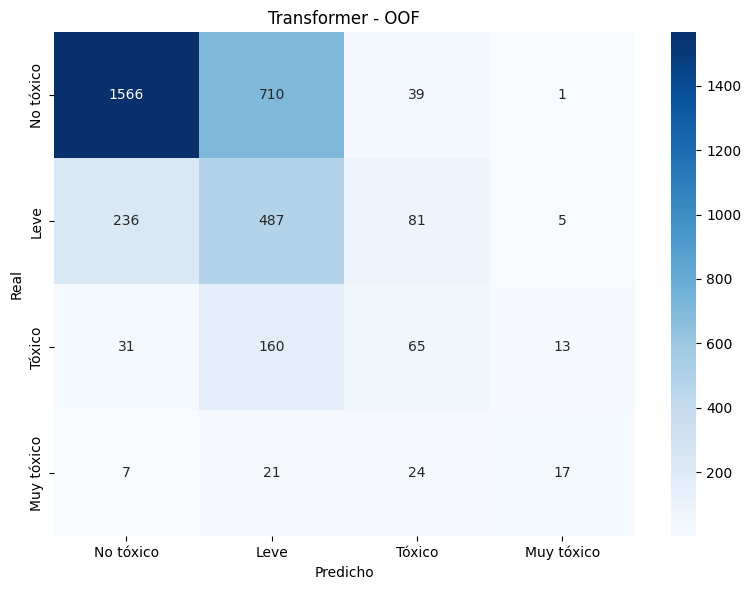


✅ Transformer Macro-F1 (OOF): 0.4487


In [27]:
# =============================================================================
# CELDA 13: ENTRENAMIENTO TRANSFORMER CON K-FOLD
# =============================================================================

print("\n" + "=" * 60)
print("🤖 TRANSFORMER CON K-FOLD")
print("=" * 60)

def train_fold(train_texts, train_labels, val_texts, val_labels,
               model_path, config, class_weights, device, fold):
    """Entrena un fold"""

    tok = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path, num_labels=config.NUM_CLASSES
    ).to(device)

    train_ds = ToxicityDataset(train_texts, train_labels, tok, config.MAX_LENGTH)
    val_ds = ToxicityDataset(val_texts, val_labels, tok, config.MAX_LENGTH)

    # Weighted sampler para oversampling
    sampler = get_weighted_sampler(train_labels) if config.ENABLE_OVERSAMPLING else None
    train_loader = DataLoader(train_ds, batch_size=config.BATCH_SIZE,
                              sampler=sampler, shuffle=(sampler is None))
    val_loader = DataLoader(val_ds, batch_size=config.BATCH_SIZE * 2, shuffle=False)

    optimizer = torch.optim.AdamW(model.parameters(), lr=config.LEARNING_RATE,
                                  weight_decay=config.WEIGHT_DECAY)
    total_steps = len(train_loader) * config.EPOCHS
    scheduler = get_linear_schedule_with_warmup(optimizer, int(total_steps * config.WARMUP_RATIO), total_steps)

    criterion = FocalLoss(alpha=class_weights, gamma=2.5)  # gamma aumentado
    scaler = GradScaler()

    best_f1 = 0
    patience = 0
    best_state = None

    for epoch in range(config.EPOCHS):
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            optimizer.zero_grad()
            with autocast():
                outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
                loss = criterion(outputs.logits, batch['labels'])
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.GRADIENT_CLIP)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            train_loss += loss.item()

        # Validación
        model.eval()
        val_proba, val_true = [], []
        with torch.no_grad():
            for batch in val_loader:
                batch = {k: v.to(device) for k, v in batch.items()}
                with autocast():
                    outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
                proba = F.softmax(outputs.logits, dim=-1)
                val_proba.append(proba.cpu().numpy())
                val_true.extend(batch['labels'].cpu().numpy())

        val_proba = np.vstack(val_proba)
        val_preds = val_proba.argmax(axis=1)
        metrics = compute_metrics(np.array(val_true), val_preds, list(config.CLASS_NAMES))

        print(f"   Epoch {epoch+1}/{config.EPOCHS} | Loss: {train_loss/len(train_loader):.4f} | "
              f"Macro-F1: {metrics['macro_f1']:.4f} | F1/clase: {[f'{f:.3f}' for f in metrics['f1_per_class']]}")

        if metrics['macro_f1'] > best_f1:
            best_f1 = metrics['macro_f1']
            patience = 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience += 1
            if patience >= config.EARLY_STOPPING_PATIENCE:
                print(f"   ⏹️ Early stopping")
                break

    if best_state:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    model.eval()
    final_proba = []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            final_proba.append(F.softmax(outputs.logits, dim=-1).cpu().numpy())

    return np.vstack(final_proba), best_f1, model

# K-Fold
X = train_df[CONFIG.TRAIN_TEXT_COL].values
y = train_df[CONFIG.LABEL_COL].values

transformer_oof_proba = np.zeros((len(X), CONFIG.NUM_CLASSES))
fold_models = []
skf = StratifiedKFold(n_splits=CONFIG.N_FOLDS, shuffle=True, random_state=CONFIG.SEED)

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n{'─'*50}")
    print(f"📁 Fold {fold}/{CONFIG.N_FOLDS}")
    print(f"{'─'*50}")

    val_proba, best_f1, model = train_fold(
        X[train_idx], y[train_idx], X[val_idx], y[val_idx],
        ADAPTED_MODEL_PATH, CONFIG, class_weights, DEVICE, fold
    )

    transformer_oof_proba[val_idx] = val_proba
    fold_models.append(model)
    clear_gpu_memory()

# Resultados
transformer_oof_preds = transformer_oof_proba.argmax(axis=1)
transformer_metrics = compute_metrics(y, transformer_oof_preds, list(CONFIG.CLASS_NAMES))

print("\n" + "=" * 60)
print("📊 TRANSFORMER - RESULTADOS OOF")
print("=" * 60)
print(transformer_metrics['report'])
plot_confusion_matrix(y, transformer_oof_preds, list(CONFIG.CLASS_NAMES), "Transformer - OOF")

print(f"\n✅ Transformer Macro-F1 (OOF): {transformer_metrics['macro_f1']:.4f}")



🔧 ENSEMBLE + OPTIMIZACIÓN
   Mejores pesos: Baseline=0.15, Transformer=0.85
🔧 Optimizando umbrales por clase...
   Bias óptimos: ['0.05', '0.00', '-0.10', '0.00']
   Macro-F1 mejorado: 0.4631

📊 ENSEMBLE - RESULTADOS OOF
              precision    recall  f1-score   support

   No tóxico     0.8314    0.7876    0.8089      2316
        Leve     0.4034    0.5315    0.4587       809
      Tóxico     0.3129    0.1896    0.2361       269
  Muy tóxico     0.4750    0.2754    0.3486        69

    accuracy                         0.6711      3463
   macro avg     0.5057    0.4460    0.4631      3463
weighted avg     0.6840    0.6711    0.6734      3463



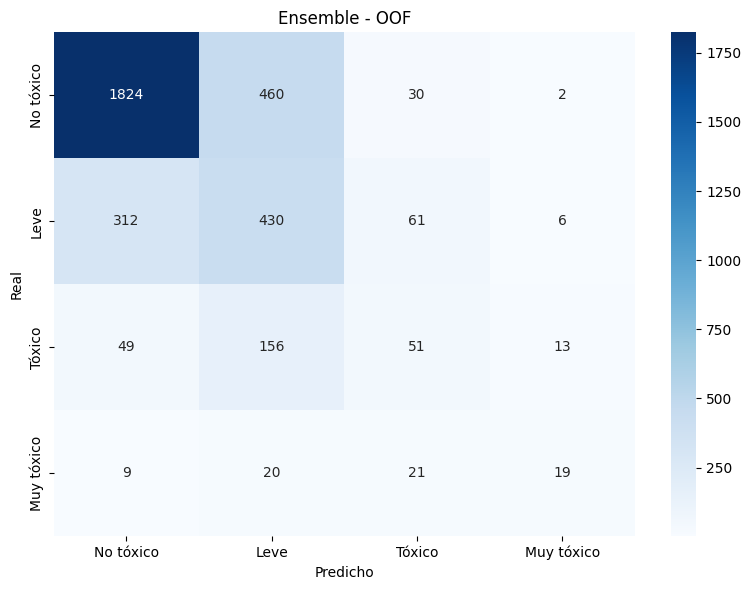


📈 COMPARACIÓN:
   Baseline:    Macro-F1 = 0.3712
   Transformer: Macro-F1 = 0.4487
   Ensemble:    Macro-F1 = 0.4631


In [28]:
# =============================================================================
# CELDA 14: ENSEMBLE + OPTIMIZACIÓN DE UMBRALES
# =============================================================================

print("\n" + "=" * 60)
print("🔧 ENSEMBLE + OPTIMIZACIÓN")
print("=" * 60)

# Optimizar pesos del ensemble
best_f1 = 0
best_weights = (0.25, 0.75)

for baseline_w in np.arange(0.0, 1.05, 0.05):
    transformer_w = 1.0 - baseline_w
    ensemble_proba = baseline_w * baseline_oof_proba + transformer_w * transformer_oof_proba
    ensemble_preds = ensemble_proba.argmax(axis=1)
    f1 = f1_score(y, ensemble_preds, average='macro')
    if f1 > best_f1:
        best_f1 = f1
        best_weights = (baseline_w, transformer_w)

print(f"   Mejores pesos: Baseline={best_weights[0]:.2f}, Transformer={best_weights[1]:.2f}")

# Ensemble base
ensemble_oof_proba = best_weights[0] * baseline_oof_proba + best_weights[1] * transformer_oof_proba

# Optimización de umbrales
if CONFIG.ENABLE_THRESHOLD_OPT:
    optimal_bias = optimize_thresholds(ensemble_oof_proba, y, CONFIG.NUM_CLASSES)
    ensemble_oof_proba_adjusted = ensemble_oof_proba + optimal_bias
    ensemble_oof_preds = ensemble_oof_proba_adjusted.argmax(axis=1)
else:
    optimal_bias = np.zeros(CONFIG.NUM_CLASSES)
    ensemble_oof_preds = ensemble_oof_proba.argmax(axis=1)

ensemble_metrics = compute_metrics(y, ensemble_oof_preds, list(CONFIG.CLASS_NAMES))

print("\n" + "=" * 60)
print("📊 ENSEMBLE - RESULTADOS OOF")
print("=" * 60)
print(ensemble_metrics['report'])
plot_confusion_matrix(y, ensemble_oof_preds, list(CONFIG.CLASS_NAMES), "Ensemble - OOF")

print("\n📈 COMPARACIÓN:")
print(f"   Baseline:    Macro-F1 = {baseline_metrics['macro_f1']:.4f}")
print(f"   Transformer: Macro-F1 = {transformer_metrics['macro_f1']:.4f}")
print(f"   Ensemble:    Macro-F1 = {ensemble_metrics['macro_f1']:.4f}")


In [29]:
# =============================================================================
# CELDA 15: PSEUDO-LABELING (OPCIONAL)
# =============================================================================

if CONFIG.ENABLE_PSEUDO_LABELING:
    print("\n" + "=" * 60)
    print("🏷️ PSEUDO-LABELING")
    print("=" * 60)

    # Predecir test con el ensemble actual
    print("   Prediciendo test para pseudo-labels...")

    # Baseline
    final_baseline_temp = TFIDFBaseline(CONFIG, use_oversampling=CONFIG.ENABLE_OVERSAMPLING)
    final_baseline_temp.fit(train_df[CONFIG.TRAIN_TEXT_COL].values, train_df[CONFIG.LABEL_COL].values)
    test_texts = test_df[CONFIG.TEST_TEXT_COL].values
    baseline_test_proba_temp = final_baseline_temp.predict_proba(test_texts)

    # Transformer
    tokenizer = AutoTokenizer.from_pretrained(ADAPTED_MODEL_PATH)
    test_ds = ToxicityDataset(test_texts, None, tokenizer, CONFIG.MAX_LENGTH)
    test_loader = DataLoader(test_ds, batch_size=CONFIG.BATCH_SIZE * 2, shuffle=False)

    transformer_test_proba_temp = []
    for fold_idx, model in enumerate(fold_models):
        model.to(DEVICE)
        model.eval()
        fold_proba = []
        with torch.no_grad():
            for batch in test_loader:
                batch = {k: v.to(DEVICE) for k, v in batch.items() if k != 'labels'}
                outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
                fold_proba.append(F.softmax(outputs.logits, dim=-1).cpu().numpy())
        transformer_test_proba_temp.append(np.vstack(fold_proba))
        model.to('cpu')

    transformer_test_proba_temp = np.mean(transformer_test_proba_temp, axis=0)
    clear_gpu_memory()

    # Ensemble para test
    test_proba_temp = best_weights[0] * baseline_test_proba_temp + best_weights[1] * transformer_test_proba_temp + optimal_bias
    test_confidence = test_proba_temp.max(axis=1)
    test_pseudo_labels = test_proba_temp.argmax(axis=1)

    # Filtrar por confianza
    confident_mask = test_confidence >= CONFIG.PSEUDO_THRESHOLD
    n_pseudo = confident_mask.sum()
    print(f"   Muestras con confianza >= {CONFIG.PSEUDO_THRESHOLD}: {n_pseudo} ({100*n_pseudo/len(test_texts):.1f}%)")

    if n_pseudo > 0:
        pseudo_dist = pd.Series(test_pseudo_labels[confident_mask]).value_counts().sort_index()
        print(f"   Distribución pseudo-labels: {dict(pseudo_dist)}")

        # Crear dataset aumentado
        pseudo_texts = test_texts[confident_mask]
        pseudo_labels = test_pseudo_labels[confident_mask]

        augmented_X = np.concatenate([train_df[CONFIG.TRAIN_TEXT_COL].values, pseudo_texts])
        augmented_y = np.concatenate([train_df[CONFIG.LABEL_COL].values, pseudo_labels])

        print(f"   Dataset aumentado: {len(augmented_X)} muestras (original: {len(train_df)})")
    else:
        print("   ⚠️ No hay suficientes pseudo-labels confiables")
        augmented_X = train_df[CONFIG.TRAIN_TEXT_COL].values
        augmented_y = train_df[CONFIG.LABEL_COL].values
else:
    print("\n⏭️ Pseudo-labeling desactivado")
    augmented_X = train_df[CONFIG.TRAIN_TEXT_COL].values
    augmented_y = train_df[CONFIG.LABEL_COL].values



🏷️ PSEUDO-LABELING
   Prediciendo test para pseudo-labels...
   Oversampling: 9264 muestras
   Muestras con confianza >= 0.9: 0 (0.0%)
   ⚠️ No hay suficientes pseudo-labels confiables


In [30]:
# =============================================================================
# CELDA 16: PREDICCIONES FINALES
# =============================================================================

print("\n" + "=" * 60)
print("🎯 PREDICCIONES FINALES")
print("=" * 60)

# Baseline final (con datos aumentados si hay pseudo-labels)
print("\n🔧 Entrenando baseline final...")
final_baseline = TFIDFBaseline(CONFIG, use_oversampling=CONFIG.ENABLE_OVERSAMPLING)
final_baseline.fit(augmented_X, augmented_y)

test_texts = test_df[CONFIG.TEST_TEXT_COL].values  # 'comment' para test
baseline_test_proba = final_baseline.predict_proba(test_texts)

# Transformer ensemble
print("🔧 Prediciendo con transformer...")
tokenizer = AutoTokenizer.from_pretrained(ADAPTED_MODEL_PATH)
test_ds = ToxicityDataset(test_texts, None, tokenizer, CONFIG.MAX_LENGTH)
test_loader = DataLoader(test_ds, batch_size=CONFIG.BATCH_SIZE * 2, shuffle=False)

all_fold_proba = []
for fold_idx, model in enumerate(fold_models):
    print(f"   Fold {fold_idx + 1}...")
    model.to(DEVICE)
    model.eval()

    fold_proba = []
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(DEVICE) for k, v in batch.items() if k != 'labels'}
            outputs = model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])
            fold_proba.append(F.softmax(outputs.logits, dim=-1).cpu().numpy())

    all_fold_proba.append(np.vstack(fold_proba))
    model.to('cpu')
    clear_gpu_memory()

transformer_test_proba = np.mean(all_fold_proba, axis=0)

# Ensemble final con bias optimizado
final_proba = best_weights[0] * baseline_test_proba + best_weights[1] * transformer_test_proba
final_proba_adjusted = final_proba + optimal_bias
final_preds = final_proba_adjusted.argmax(axis=1)

print(f"\n✅ Predicciones: {len(final_preds)} muestras")

print("\n📊 Distribución de predicciones:")
for i, name in enumerate(CONFIG.CLASS_NAMES):
    count = (final_preds == i).sum()
    print(f"   Clase {i} ({name}): {count} ({100*count/len(final_preds):.1f}%)")



🎯 PREDICCIONES FINALES

🔧 Entrenando baseline final...
   Oversampling: 9264 muestras
🔧 Prediciendo con transformer...
   Fold 1...
   Fold 2...
   Fold 3...
   Fold 4...
   Fold 5...

✅ Predicciones: 891 muestras

📊 Distribución de predicciones:
   Clase 0 (No tóxico): 584 (65.5%)
   Clase 1 (Leve): 277 (31.1%)
   Clase 2 (Tóxico): 24 (2.7%)
   Clase 3 (Muy tóxico): 6 (0.7%)


In [31]:
# =============================================================================
# CELDA 17: GUARDAR RESULTADOS
# =============================================================================

# Submission
submission = pd.DataFrame({
    'id': test_df[CONFIG.ID_COL],
    'label': final_preds
})
submission_path = os.path.join(CONFIG.OUTPUT_DIR, 'submission.csv')
submission.to_csv(submission_path, index=False)

# También guardar en Drive si está montado
drive_path = '/content/drive/MyDrive/submission_detoxis.csv'
try:
    submission.to_csv(drive_path, index=False)
    print(f"✅ Submission guardado en Drive: {drive_path}")
except:
    pass

# OOF
oof_df = train_df[[CONFIG.ID_COL, CONFIG.LABEL_COL]].copy()
oof_df['pred_baseline'] = baseline_oof_preds
oof_df['pred_transformer'] = transformer_oof_preds
oof_df['pred_ensemble'] = ensemble_oof_preds
for i in range(CONFIG.NUM_CLASSES):
    oof_df[f'proba_{i}'] = ensemble_oof_proba[:, i]
oof_path = os.path.join(CONFIG.OUTPUT_DIR, 'oof_predictions.csv')
oof_df.to_csv(oof_path, index=False)

# Métricas
metrics_dict = {
    'baseline_macro_f1': float(baseline_metrics['macro_f1']),
    'baseline_f1_per_class': [float(f) for f in baseline_metrics['f1_per_class']],
    'transformer_macro_f1': float(transformer_metrics['macro_f1']),
    'transformer_f1_per_class': [float(f) for f in transformer_metrics['f1_per_class']],
    'ensemble_macro_f1': float(ensemble_metrics['macro_f1']),
    'ensemble_f1_per_class': [float(f) for f in ensemble_metrics['f1_per_class']],
    'weights': {'baseline': best_weights[0], 'transformer': best_weights[1]},
    'optimal_bias': optimal_bias.tolist(),
    'model': MODEL_NAME,
    'config': {
        'n_folds': CONFIG.N_FOLDS,
        'max_length': CONFIG.MAX_LENGTH,
        'batch_size': CONFIG.BATCH_SIZE,
        'epochs': CONFIG.EPOCHS,
        'oversampling': CONFIG.ENABLE_OVERSAMPLING,
        'pseudo_labeling': CONFIG.ENABLE_PSEUDO_LABELING,
        'threshold_opt': CONFIG.ENABLE_THRESHOLD_OPT
    }
}
with open(os.path.join(CONFIG.OUTPUT_DIR, 'metrics.json'), 'w') as f:
    json.dump(metrics_dict, f, indent=2)

print("\n" + "=" * 60)
print("🎉 ¡COMPLETADO!")
print("=" * 60)
print(f"\n📁 Archivos en {CONFIG.OUTPUT_DIR}:")
print(f"   📝 submission.csv")
print(f"   📝 oof_predictions.csv")
print(f"   📝 metrics.json")

print("\n📄 SUBMISSION (primeras 15 filas):")
print(submission.head(15).to_string(index=False))

print("\n\n📊 RESUMEN FINAL:")
print(f"   Mejor modelo: Ensemble (Baseline {best_weights[0]:.0%} + Transformer {best_weights[1]:.0%})")
print(f"   Macro-F1 OOF: {ensemble_metrics['macro_f1']:.4f}")
print(f"   F1 por clase: {[f'{f:.4f}' for f in ensemble_metrics['f1_per_class']]}")


✅ Submission guardado en Drive: /content/drive/MyDrive/submission_detoxis.csv

🎉 ¡COMPLETADO!

📁 Archivos en /outputs:
   📝 submission.csv
   📝 oof_predictions.csv
   📝 metrics.json

📄 SUBMISSION (primeras 15 filas):
 id  label
  0      1
  1      1
  2      1
  3      0
  4      1
  5      0
  6      1
  7      0
  8      0
  9      0
 10      1
 11      0
 12      1
 13      1
 14      0


📊 RESUMEN FINAL:
   Mejor modelo: Ensemble (Baseline 15% + Transformer 85%)
   Macro-F1 OOF: 0.4631
   F1 por clase: ['0.8089', '0.4587', '0.2361', '0.3486']
